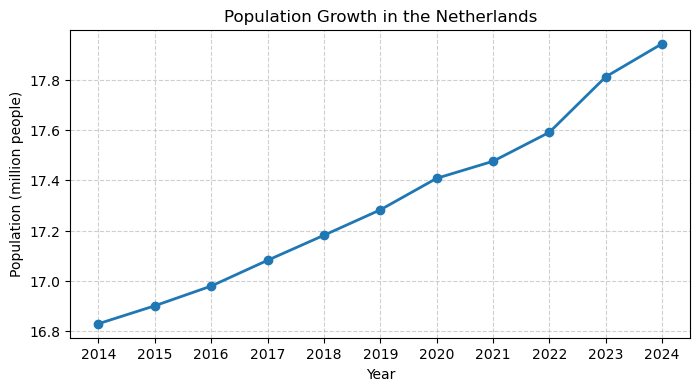

In [41]:
#Part 1: Data filtering
df = pd.read_csv('bontwikkeling.csv', sep=';', skiprows=3)  # Read CSV, skip first 3 rows

df.columns = df.columns.str.strip()  # Remove any leading/trailing spaces in column names
df = df.rename(columns={'Unnamed: 0': 'Year', 'Bevolking aan het begin van de periode': 'Population'})  # Rename columns

df = df[pd.to_numeric(df['Population'], errors='coerce').notna()]  # Remove rows without numeric population values
df['Year'] = df['Year'].astype(int)  # Convert 'Year' to integer
df['Population'] = df['Population'].astype(int) / 1_000_000  # Convert population to millions

#Part 2: Plotting
plt.figure(figsize=(8, 4))  # Create a new figure with a specific size
ax = plt.gca()  # Get the current axis for plotting

ax.plot(df['Year'], df['Population'], marker='o', color='tab:blue', linewidth=2)  # Plot population over the years

ax.set_title("Population Growth in the Netherlands")  # Set the plot title
ax.set_xlabel("Year")  # Set x-axis label
ax.set_ylabel("Population (million people)")  # Set y-axis label

ax.grid(True, linestyle='--', alpha=0.6)  # Add grid with dashed lines and 60% transparency
ax.set_xticks(df['Year'])  # Set x-axis ticks to the years

plt.show()  # Display the plot




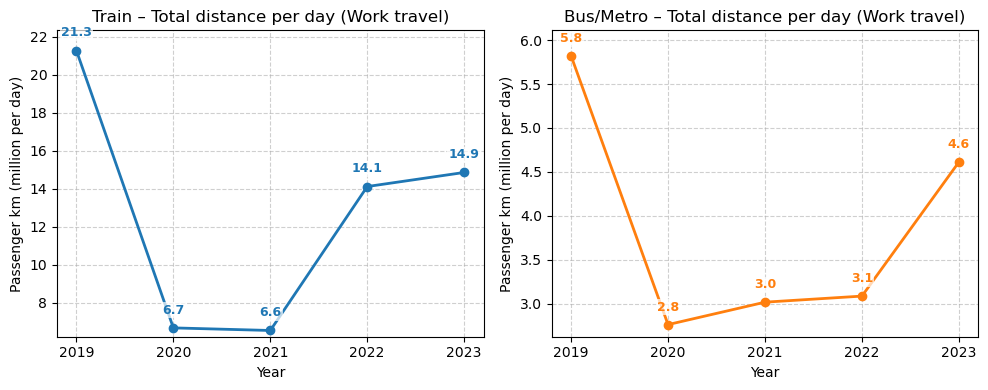

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Read data
df = pd.read_csv("PT trend.csv", sep=';', skiprows=5)  # Read CSV file, skip first 5 rows

# Set column names
df.columns = [
    "Periods", "Age", "Travel_motives",
    "Train_stages", "Train_distance", "Train_time",
    "BusMetro_stages", "BusMetro_distance", "BusMetro_time"
]

# Filter for work-related travel
df_work = df[df["Travel_motives"].str.contains("work", case=False, na=False)].copy()  # Filter rows with 'work' in Travel_motives

# Extract year from 'Periods' column (handles '2019*' cases too)
df_work["Year"] = df_work["Periods"].str.extract(r"(\d{4})").astype(int)  # Extract year from the 'Periods' column

# Convert numeric columns, replace commas with periods for correct conversion
cols = ["Train_stages", "Train_distance", "BusMetro_stages", "BusMetro_distance"]
df_work[cols] = df_work[cols].apply(lambda x: x.astype(str).str.replace(",", ".")).astype(float)  # Convert to float

# Calculate total per person per day
df_work["Train_total_per_person"] = df_work["Train_stages"] * df_work["Train_distance"]  # Calculate total for train
df_work["BusMetro_total_per_person"] = df_work["BusMetro_stages"] * df_work["BusMetro_distance"]  # Calculate total for bus/metro

# === 2. Read population data ===
pop = pd.read_csv("bontwikkeling.csv", sep=';', skiprows=4)  # Read population data
pop.columns = ["Year", "Population"]  # Set column names
pop = pop[pop["Year"].str.match(r"^\d{4}$", na=False)]  # Filter rows with valid year format
pop["Year"] = pop["Year"].astype(int)  # Convert 'Year' to integer
pop["Population"] = pd.to_numeric(pop["Population"], errors="coerce")  # Convert 'Population' to numeric

# === 3. Merge data and calculations ===
merged = pd.merge(df_work, pop, on="Year", how="left")  # Merge data on 'Year'

# Calculate total km per day (in millions)
merged["Train_total_km_per_day"] = merged["Train_total_per_person"] * merged["Population"] / 1_000_000  # Total km per day for train
merged["BusMetro_total_km_per_day"] = merged["BusMetro_total_per_person"] * merged["Population"] / 1_000_000  # Total km per day for bus/metro

# Ensure 'Year' is integer type
merged["Year"] = merged["Year"].astype(int)

# === 4. Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create two subplots

def plot_mode(ax, x, y, title, color):
    ax.plot(x, y, marker='o', color=color, linewidth=2)  # Plot data with markers
    ax.set_title(title)  # Set title
    ax.set_xlabel("Year")  # Set x-axis label
    ax.set_ylabel("Passenger km (million per day)")  # Set y-axis label
    ax.set_xticks(x.astype(int))  # Set x-axis ticks to years
    ax.grid(True, linestyle='--', alpha=0.6)  # Add grid with dashed lines

    # Adjust y-axis limits for better visibility
    if y.notna().any():
        ymin, ymax = y.min() * 0.95, y.max() * 1.05  # Set y-limits with 5% margin
        ax.set_ylim(ymin, ymax)

    # Add labels to data points
    for xi, yi in zip(x, y):  # Loop through data points
        if pd.notna(yi):
            ax.text(
                xi, yi + (y.max() - y.min()) * 0.04,  # Slightly higher offset for better visibility
                f"{yi:.1f}",
                ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                color=color,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)  # Add label with background
            )

# Plot for Train and Bus/Metro data
plot_mode(axes[0], merged["Year"], merged["Train_total_km_per_day"],
          "Train – Total distance per day (Work travel)", "tab:blue")
plot_mode(axes[1], merged["Year"], merged["BusMetro_total_km_per_day"],
          "Bus/Metro – Total distance per day (Work travel)", "tab:orange")

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()  # Display the plot


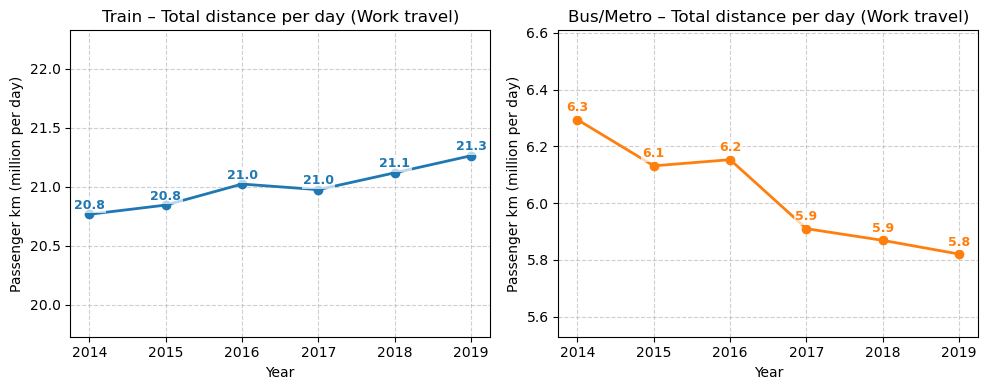

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Read old PT-trend data (2014–2019) ===
df_before = pd.read_csv("PTbefore.csv", sep=';', skiprows=5)  # Read the CSV, skip first 5 rows

# Set column names (same structure as new dataset)
df_before.columns = [
    "Periods", "Age", "Travel_motives",
    "Train_stages", "Train_distance", "Train_time",
    "BusMetro_stages", "BusMetro_distance", "BusMetro_time"
]

# Filter for work-related travel
df_before_work = df_before[df_before["Travel_motives"].str.contains("work", case=False, na=False)].copy()  # Filter rows with 'work' in Travel_motives

# Extract year from 'Periods' column
df_before_work["Year"] = df_before_work["Periods"].str.extract(r"(\d{4})").astype(int)  # Extract year from the 'Periods' column

# Replace commas with periods and convert to float
cols = ["Train_stages", "Train_distance", "BusMetro_stages", "BusMetro_distance"]
df_before_work[cols] = df_before_work[cols].apply(lambda x: x.astype(str).str.replace(",", ".")).astype(float)  # Convert to float

# Calculate total per person per day
df_before_work["Train_total_per_person"] = df_before_work["Train_stages"] * df_before_work["Train_distance"]  # Calculate total for train
df_before_work["BusMetro_total_per_person"] = df_before_work["BusMetro_stages"] * df_before_work["BusMetro_distance"]  # Calculate total for bus/metro

# === 2. Read population data ===
pop = pd.read_csv("bontwikkeling.csv", sep=';', skiprows=4)  # Read population data
pop.columns = ["Year", "Population"]  # Set column names
pop = pop[pop["Year"].str.match(r"^\d{4}$", na=False)]  # Filter rows with valid year format
pop["Year"] = pop["Year"].astype(int)  # Convert 'Year' to integer
pop["Population"] = pd.to_numeric(pop["Population"], errors="coerce")  # Convert 'Population' to numeric

# === 3. Merge data and calculations ===
merged_before = pd.merge(df_before_work, pop, on="Year", how="left")  # Merge data on 'Year'

# Calculate total km per day (in millions)
merged_before["Train_total_km_per_day"] = (
    merged_before["Train_total_per_person"] * merged_before["Population"] / 1_000_000  # Total km per day for train
)
merged_before["BusMetro_total_km_per_day"] = (
    merged_before["BusMetro_total_per_person"] * merged_before["Population"] / 1_000_000  # Total km per day for bus/metro
)

# Ensure 'Year' is integer type
merged_before["Year"] = merged_before["Year"].astype(int)

# === 4. Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create two subplots

def plot_mode(ax, x, y, title, color):
    ax.plot(x, y, marker='o', color=color, linewidth=2)  # Plot data with markers
    ax.set_title(title)  # Set title
    ax.set_xlabel("Year")  # Set x-axis label
    ax.set_ylabel("Passenger km (million per day)")  # Set y-axis label
    ax.set_xticks(x.astype(int))  # Set x-axis ticks to years
    ax.grid(True, linestyle='--', alpha=0.6)  # Add grid with dashed lines

    # Adjust y-axis limits for better visibility
    if y.notna().any():
        ymin, ymax = y.min() * 0.95, y.max() * 1.05  # Set y-limits with 5% margin
        ax.set_ylim(ymin, ymax)

    # Add labels to data points
    for xi, yi in zip(x, y):  # Loop through data points
        if pd.notna(yi):
            ax.text(
                xi, yi + (y.max() - y.min()) * 0.04,  # Slightly higher offset for better visibility
                f"{yi:.1f}",
                ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                color=color,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)  # Add label with background
            )

# Plot for Train and Bus/Metro data
plot_mode(axes[0], merged_before["Year"], merged_before["Train_total_km_per_day"],
          "Train – Total distance per day (Work travel)", "tab:blue")
plot_mode(axes[1], merged_before["Year"], merged_before["BusMetro_total_km_per_day"],
          "Bus/Metro – Total distance per day (Work travel)", "tab:orange")

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()  # Display the plot


In [20]:
import matplotlib.ticker as mticker

# Converteer naar “duizenden duizend-uren” → in de grafiek staat dus bijv. 21.4 = 21 400 uur
merged_before["Train_total_hours_per_day_thousand"] /= 1000
merged_before["BusMetro_total_hours_per_day_thousand"] /= 1000

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def plot_mode(ax, x, y, title, color):
    ax.plot(x, y, marker='o', color=color, linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Total travel time (thousand hours per day)")
    ax.set_xticks(x.astype(int))
    ax.grid(True, linestyle='--', alpha=0.6)

    # Y-limiets iets strakker (±3% marge)
    if y.notna().any():
        ymin, ymax = y.min() * 0.97, y.max() * 1.03
        ax.set_ylim(ymin, ymax)

    # Aslabels met 1 decimaal
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

    # Datapunten tonen
    for xi, yi in zip(x, y):
        if pd.notna(yi):
            ax.text(
                xi, yi + (y.max() - y.min()) * 0.015,
                f"{yi:.1f}", ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                color=color,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
            )

plot_mode(axes[0], merged_before["Year"], merged_before["Train_total_hours_per_day_thousand"],
          "Train – Total travel time per day (Work travel)", "tab:blue")
plot_mode(axes[1], merged_before["Year"], merged_before["BusMetro_total_hours_per_day_thousand"],
          "Bus/Metro – Total travel time per day (Work travel)", "tab:orange")

plt.tight_layout()
plt.show()


KeyError: 'Train_total_hours_per_day_thousand'